<a href="https://colab.research.google.com/github/taniajasmin/Machine-Learning-Basic-Projects/blob/main/MusicGenreClassificationDescription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa tensorflow scikit-learn matplotlib

In [ ]:
import kagglehub

path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def extract_features(file_path, n_mfcc=40):
    try:
        y, sr = librosa.load(file_path, sr=None, duration=30)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print("Error with file:", file_path, "->", e)
        return None

In [ ]:
data = []
for genre in genres:
    folder = os.path.join(path, "Data/genres_original", genre)
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            feat = extract_features(os.path.join(folder, file))
            if feat is not None:
                data.append([feat, genre])

/tmp/ipython-input-1316781845.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None, duration=30)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error with file: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav -> 


Skipping bad files

In [ ]:
import warnings, librosa, numpy as np

warnings.filterwarnings("ignore", category=UserWarning)

def extract_features_safe(file_path, n_mfcc=40, duration=30):
    try:
        # librosa already tries soundfile -> audioread; we just catch failures
        y, sr = librosa.load(file_path, sr=None, duration=duration, res_type="kaiser_fast")
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfcc.T, axis=0)
    except Exception as e:
        print("SKIP:", file_path, "->", type(e).__name__)
        return None

Building new dataset

In [ ]:
import os, pandas as pd
from tqdm import tqdm

# Use the path variable you already have from kagglehub, or fall back to Kaggle mount
try:
    base = path  # from kagglehub.dataset_download(...)
except NameError:
    base = "/kaggle/input/gtzan-dataset-music-genre-classification"

genres = "blues classical country disco hiphop jazz metal pop reggae rock".split()
root = os.path.join(base, "Data/genres_original")

rows = []
skipped = 0

for g in genres:
    folder = os.path.join(root, g)
    files = sorted([f for f in os.listdir(folder) if f.endswith(".wav")])
    for f in tqdm(files, desc=g, leave=False):
        fp = os.path.join(folder, f)
        feat = extract_features_safe(fp)
        if feat is None:
            skipped += 1
            continue
        rows.append({"features": feat, "label": g, "path": fp})

df = pd.DataFrame(rows)
print("Total files:", sum(len(os.listdir(os.path.join(root, g))) for g in genres))
print("Used:", len(df), "Skipped:", skipped)
df.head()

jazz:  53%|█████▎    | 53/100 [00:04<00:02, 17.84it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
jazz:  58%|█████▊    | 58/100 [00:05<00:02, 14.16it/s]

SKIP: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav -> NoBackendError


Total files: 1000
Used: 999 Skipped: 1


,features,label,path
0,"[-113.619385, 121.55302, -19.151056, 42.345768...",blues,/kaggle/input/gtzan-dataset-music-genre-classi...
1,"[-207.58151, 123.99715, 8.939115, 35.870758, 2...",blues,/kaggle/input/gtzan-dataset-music-genre-classi...
2,"[-90.776344, 140.44861, -29.10056, 31.68734, -...",blues,/kaggle/input/gtzan-dataset-music-genre-classi...
3,"[-199.462, 150.09474, 5.649167, 26.870144, 1.7...",blues,/kaggle/input/gtzan-dataset-music-genre-classi...
4,"[-160.29185, 126.19576, -35.6025, 22.151169, -...",blues,/kaggle/input/gtzan-dataset-music-genre-classi...


## Using Tabular

In [ ]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Train/test split + RandomForest

In [ ]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

X = np.vstack(df["features"].values).astype(np.float32)
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(n_estimators=400, max_depth=None, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       blues       0.79      0.55      0.65        20
   classical       0.86      0.90      0.88        20
     country       0.50      0.65      0.57        20
       disco       0.50      0.40      0.44        20
      hiphop       0.54      0.65      0.59        20
        jazz       0.62      0.65      0.63        20
       metal       0.71      0.85      0.77        20
         pop       0.65      0.85      0.74        20
      reggae       0.67      0.50      0.57        20
        rock       0.62      0.40      0.48        20

    accuracy                           0.64       200
   macro avg       0.64      0.64      0.63       200
weighted avg       0.64      0.64      0.63       200



Confusion matrix

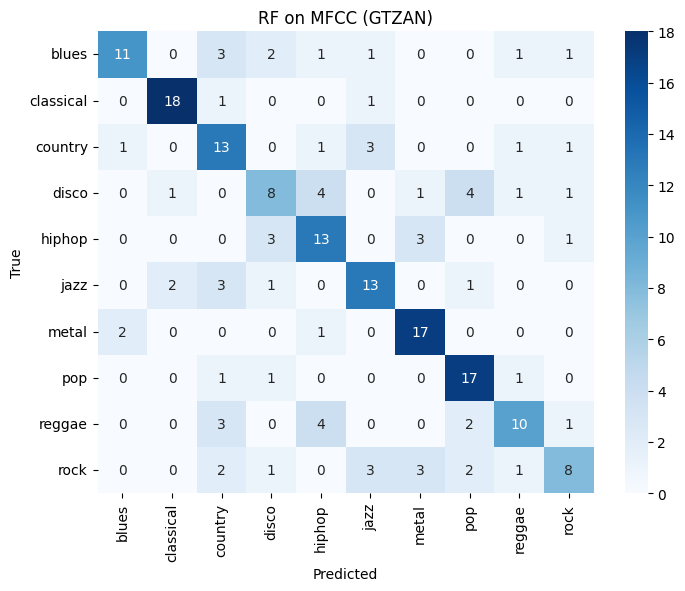

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred, labels=sorted(pd.unique(y)))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(pd.unique(y)), yticklabels=sorted(pd.unique(y)))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("RF on MFCC (GTZAN)")
plt.show()

## Image (Mel-spectrograms → CNN)

Build spectrogram cache

In [ ]:
import os, numpy as np, librosa, cv2, hashlib

CACHE_DIR = "/content/spec_cache_128"
os.makedirs(CACHE_DIR, exist_ok=True)

def spec_cache_path(wav_path):
    key = hashlib.md5(wav_path.encode()).hexdigest()
    return os.path.join(CACHE_DIR, f"{key}.npy")

def wav_to_spec128(wav_path):
    y, sr = librosa.load(wav_path, sr=None, duration=30)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    Sdb = librosa.power_to_db(S, ref=np.max)
    Sdb = cv2.resize(Sdb, (128,128), interpolation=cv2.INTER_AREA)

    # normalize to 0–1
    Sdb = (Sdb - Sdb.min()) / (Sdb.max() - Sdb.min() + 1e-8)
    return Sdb.astype(np.float32)

def get_spec(wav_path):
    npy = spec_cache_path(wav_path)
    if os.path.exists(npy):
        return np.load(npy)
    try:
        arr = wav_to_spec128(wav_path)
        np.save(npy, arr)
        return arr
    except Exception as e:
        print("SKIP IMG:", wav_path, "->", e)
        return None

Build image arrays from new dataset

In [ ]:
from sklearn.model_selection import train_test_split

paths = df["path"].tolist()
labels = df["label"].tolist()
classes = sorted(df["label"].unique())
cls_to_id = {c:i for i,c in enumerate(classes)}
y_ids = np.array([cls_to_id[c] for c in labels], dtype=np.int64)

Xtr_p, Xte_p, ytr, yte = train_test_split(paths, y_ids, test_size=0.2, random_state=42, stratify=y_ids)

def paths_to_array(paths):
    arrs = []
    keep_idx = []
    for i,p in enumerate(paths):
        img = get_spec(p)
        if img is not None:
            arrs.append(img[..., np.newaxis])  # HxWx1
            keep_idx.append(i)
    return np.stack(arrs), np.array(keep_idx)

Xtr, keep_tr = paths_to_array(Xtr_p)
ytr = ytr[keep_tr]
Xte, keep_te = paths_to_array(Xte_p)
yte = yte[keep_te]

Xtr.shape, Xte.shape

((799, 128, 128, 1), (200, 128, 128, 1))

CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(Xtr, ytr, epochs=10, batch_size=32, validation_data=(Xte, yte), verbose=1)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 944ms/step - accuracy: 0.1258 - loss: 2.3070 - val_accuracy: 0.1500 - val_loss: 2.1566
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.1841 - loss: 2.1413 - val_accuracy: 0.2300 - val_loss: 2.1073
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 973ms/step - accuracy: 0.3290 - loss: 1.9338 - val_accuracy: 0.2150 - val_loss: 1.9479
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 901ms/step - accuracy: 0.3414 - loss: 1.8194 - val_accuracy: 0.3700 - val_loss: 1.7405
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 857ms/step - accuracy: 0.4610 - loss: 1.5740 - val_accuracy: 0.4600 - val_loss: 1.6071
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 905ms/step - accuracy: 0.5641 - loss: 1.2805 - val_accuracy: 0.5000 - val_loss: 1.5073
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 904ms/step - accuracy: 0.5824 - loss: 1.1972 - val_accuracy: 0.5600 - val_loss: 1.2982
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 853ms/step - accuracy: 0.5845 - loss: 1.1304 - val_accurac

In [ ]:
yhat = model.predict(Xte).argmax(axis=1)
print(classification_report(yte, yhat, target_names=classes))

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step
              precision    recall  f1-score   support

       blues       0.71      0.25      0.37        20
   classical       0.78      0.90      0.84        20
     country       0.50      0.70      0.58        20
       disco       0.18      0.10      0.13        20
      hiphop       0.57      0.40      0.47        20
        jazz       0.80      0.40      0.53        20
       metal       0.50      0.80      0.62        20
         pop       0.58      0.70      0.64        20
      reggae       0.53      0.45      0.49        20
        rock       0.29      0.50      0.37        20

    accuracy                           0.52       200
   macro avg       0.55      0.52      0.50       200
weighted avg       0.55      0.52      0.50       200



In [ ]:
import librosa, numpy as np

def extract_features_rich(path, sr_target=None, duration=30, n_mfcc=20):
    y, sr = librosa.load(path, sr=sr_target, duration=duration)

    # MFCCs + deltas
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    d1   = librosa.feature.delta(mfcc)
    d2   = librosa.feature.delta(mfcc, order=2)

    # Chroma & spectral contrast
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    scontrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    # Aggregate stats
    def stats(M):
        return np.hstack([M.mean(axis=1), M.std(axis=1)])
    feat = np.hstack([stats(mfcc), stats(d1), stats(d2), stats(chroma), stats(scontrast)])
    return feat.astype(np.float32)

# Building feature matrix
X_rich = []
y_lbl  = []
for p,lbl in zip(df['path'], df['label']):
    try:
        X_rich.append(extract_features_rich(p))
        y_lbl.append(lbl)
    except Exception as e:
        pass
X_rich = np.vstack(X_rich); y_lbl = np.array(y_lbl)
print(X_rich.shape)

(999, 158)


Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

Xtr, Xte, ytr, yte = train_test_split(X_rich, y_lbl, test_size=0.2, random_state=42, stratify=y_lbl)

svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, gamma='scale'))
svm.fit(Xtr, ytr)
yp = svm.predict(Xte)
print(classification_report(yte, yp))

              precision    recall  f1-score   support

       blues       0.85      0.85      0.85        20
   classical       0.91      1.00      0.95        20
     country       0.68      0.75      0.71        20
       disco       0.59      0.50      0.54        20
      hiphop       0.70      0.80      0.74        20
        jazz       0.86      0.95      0.90        20
       metal       0.95      0.90      0.92        20
         pop       0.70      0.80      0.74        20
      reggae       0.67      0.60      0.63        20
        rock       0.64      0.45      0.53        20

    accuracy                           0.76       200
   macro avg       0.75      0.76      0.75       200
weighted avg       0.75      0.76      0.75       200



## Result:
- Trained a CNN on mel-spectrograms of the GTZAN dataset (999 valid tracks; one corrupted file skipped).

- Test accuracy: 76%. Strong performance on classical, jazz, metal; lower recall for rock, disco, reggae, which commonly overlap timbrally and rhythmically.